# Auto Encoder Task

---






In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import os
from google.colab import output
output.enable_custom_widget_manager()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import torchvision.transforms as transforms

In [2]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

train_transform = transforms.Compose([transforms.ToTensor(),])
test_transform = transforms.Compose([transforms.ToTensor(),])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



## Define Convolutional Autoencoder

In [3]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(in_features=3*3*32, out_features=128),
            nn.ReLU(True),
            nn.Linear(in_features=128, out_features=encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(in_features=encoded_space_dim, out_features=128),
            nn.ReLU(True),
            nn.Linear(in_features=128, out_features=3*3*32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, output_padding=0),
            #nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, 
            padding=1, output_padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

## Initialize Loss function and the optimizer

In [4]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=encoded_space_dim,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=encoded_space_dim,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Train and evaluate model

In [5]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [6]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## how the autoencoder is learning from the input images

In [7]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

## train the model on the training set and evaluate it on the validation set

	 partial train loss (single batch): 0.177767
	 partial train loss (single batch): 0.182029
	 partial train loss (single batch): 0.176814
	 partial train loss (single batch): 0.180776
	 partial train loss (single batch): 0.181535
	 partial train loss (single batch): 0.179533
	 partial train loss (single batch): 0.176890
	 partial train loss (single batch): 0.177532
	 partial train loss (single batch): 0.174426
	 partial train loss (single batch): 0.179011
	 partial train loss (single batch): 0.177892
	 partial train loss (single batch): 0.175087
	 partial train loss (single batch): 0.176651
	 partial train loss (single batch): 0.175571
	 partial train loss (single batch): 0.172896
	 partial train loss (single batch): 0.173745
	 partial train loss (single batch): 0.170417
	 partial train loss (single batch): 0.176267
	 partial train loss (single batch): 0.172267
	 partial train loss (single batch): 0.172880
	 partial train loss (single batch): 0.170558
	 partial train loss (single batch

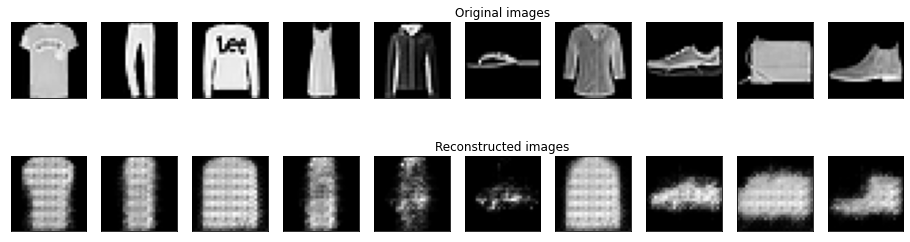

	 partial train loss (single batch): 0.044002
	 partial train loss (single batch): 0.043147
	 partial train loss (single batch): 0.045024
	 partial train loss (single batch): 0.044093
	 partial train loss (single batch): 0.041687
	 partial train loss (single batch): 0.040471
	 partial train loss (single batch): 0.043557
	 partial train loss (single batch): 0.040973
	 partial train loss (single batch): 0.041003
	 partial train loss (single batch): 0.041292
	 partial train loss (single batch): 0.040571
	 partial train loss (single batch): 0.042838
	 partial train loss (single batch): 0.042542
	 partial train loss (single batch): 0.041211
	 partial train loss (single batch): 0.041483
	 partial train loss (single batch): 0.040004
	 partial train loss (single batch): 0.038184
	 partial train loss (single batch): 0.040339
	 partial train loss (single batch): 0.038477
	 partial train loss (single batch): 0.039153
	 partial train loss (single batch): 0.039988
	 partial train loss (single batch

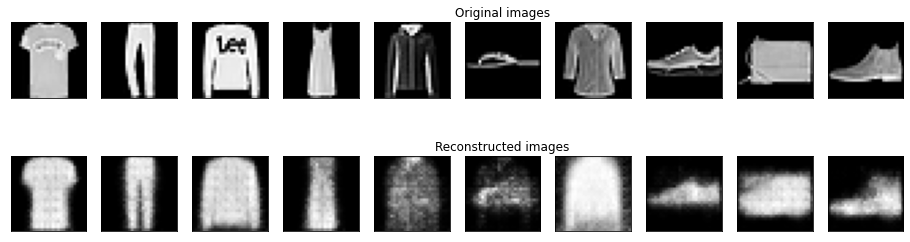

	 partial train loss (single batch): 0.028204
	 partial train loss (single batch): 0.027247
	 partial train loss (single batch): 0.028958
	 partial train loss (single batch): 0.027428
	 partial train loss (single batch): 0.028120
	 partial train loss (single batch): 0.026485
	 partial train loss (single batch): 0.027861
	 partial train loss (single batch): 0.028982
	 partial train loss (single batch): 0.027699
	 partial train loss (single batch): 0.028889
	 partial train loss (single batch): 0.028315
	 partial train loss (single batch): 0.029355
	 partial train loss (single batch): 0.029537
	 partial train loss (single batch): 0.029100
	 partial train loss (single batch): 0.028807
	 partial train loss (single batch): 0.027329
	 partial train loss (single batch): 0.027023
	 partial train loss (single batch): 0.028593
	 partial train loss (single batch): 0.027554
	 partial train loss (single batch): 0.027618
	 partial train loss (single batch): 0.030106
	 partial train loss (single batch

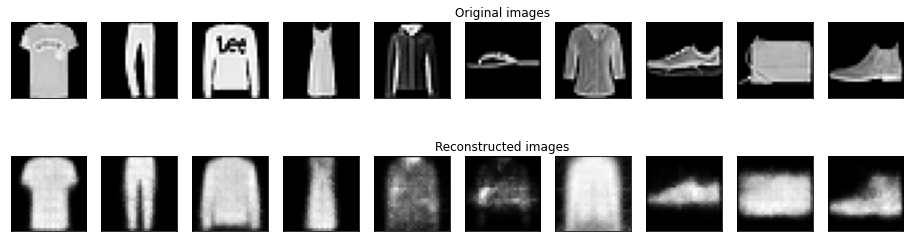

	 partial train loss (single batch): 0.025524
	 partial train loss (single batch): 0.024710
	 partial train loss (single batch): 0.026562
	 partial train loss (single batch): 0.024863
	 partial train loss (single batch): 0.025878
	 partial train loss (single batch): 0.023880
	 partial train loss (single batch): 0.025286
	 partial train loss (single batch): 0.026947
	 partial train loss (single batch): 0.025457
	 partial train loss (single batch): 0.026581
	 partial train loss (single batch): 0.026465
	 partial train loss (single batch): 0.027184
	 partial train loss (single batch): 0.027209
	 partial train loss (single batch): 0.026725
	 partial train loss (single batch): 0.026581
	 partial train loss (single batch): 0.024993
	 partial train loss (single batch): 0.024914
	 partial train loss (single batch): 0.026087
	 partial train loss (single batch): 0.025079
	 partial train loss (single batch): 0.025404
	 partial train loss (single batch): 0.028042
	 partial train loss (single batch

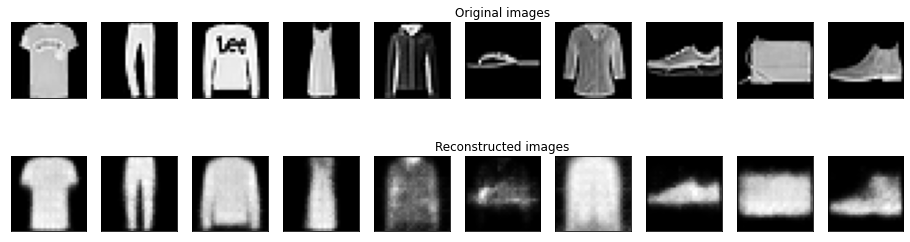

	 partial train loss (single batch): 0.024417
	 partial train loss (single batch): 0.023764
	 partial train loss (single batch): 0.025586
	 partial train loss (single batch): 0.023754
	 partial train loss (single batch): 0.024816
	 partial train loss (single batch): 0.022713
	 partial train loss (single batch): 0.024180
	 partial train loss (single batch): 0.025856
	 partial train loss (single batch): 0.024315
	 partial train loss (single batch): 0.025485
	 partial train loss (single batch): 0.025496
	 partial train loss (single batch): 0.026022
	 partial train loss (single batch): 0.026106
	 partial train loss (single batch): 0.025588
	 partial train loss (single batch): 0.025602
	 partial train loss (single batch): 0.023870
	 partial train loss (single batch): 0.023867
	 partial train loss (single batch): 0.024912
	 partial train loss (single batch): 0.023997
	 partial train loss (single batch): 0.024242
	 partial train loss (single batch): 0.027075
	 partial train loss (single batch

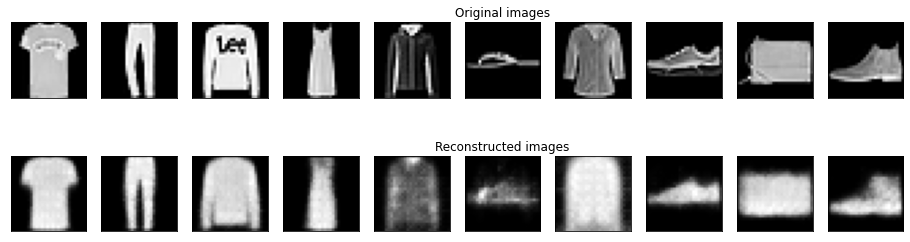

	 partial train loss (single batch): 0.023754
	 partial train loss (single batch): 0.023132
	 partial train loss (single batch): 0.024836
	 partial train loss (single batch): 0.023129
	 partial train loss (single batch): 0.024016
	 partial train loss (single batch): 0.021948
	 partial train loss (single batch): 0.023488
	 partial train loss (single batch): 0.025104
	 partial train loss (single batch): 0.023506
	 partial train loss (single batch): 0.024680
	 partial train loss (single batch): 0.024819
	 partial train loss (single batch): 0.025239
	 partial train loss (single batch): 0.025462
	 partial train loss (single batch): 0.024748
	 partial train loss (single batch): 0.024926
	 partial train loss (single batch): 0.023105
	 partial train loss (single batch): 0.023075
	 partial train loss (single batch): 0.024167
	 partial train loss (single batch): 0.023225
	 partial train loss (single batch): 0.023395
	 partial train loss (single batch): 0.026341
	 partial train loss (single batch

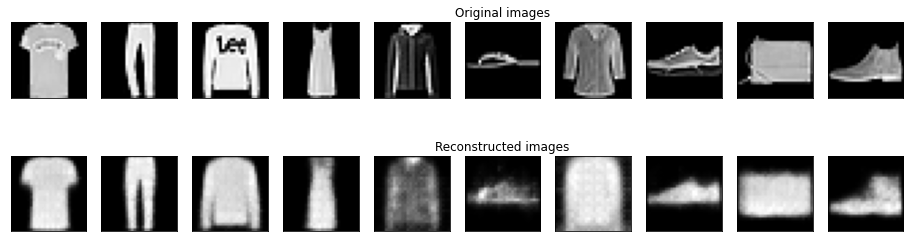

	 partial train loss (single batch): 0.023330
	 partial train loss (single batch): 0.022646
	 partial train loss (single batch): 0.024228
	 partial train loss (single batch): 0.022646
	 partial train loss (single batch): 0.023410
	 partial train loss (single batch): 0.021437
	 partial train loss (single batch): 0.022922
	 partial train loss (single batch): 0.024493
	 partial train loss (single batch): 0.023017
	 partial train loss (single batch): 0.024081
	 partial train loss (single batch): 0.024318
	 partial train loss (single batch): 0.024656
	 partial train loss (single batch): 0.024995
	 partial train loss (single batch): 0.024147
	 partial train loss (single batch): 0.024367
	 partial train loss (single batch): 0.022574
	 partial train loss (single batch): 0.022509
	 partial train loss (single batch): 0.023531
	 partial train loss (single batch): 0.022616
	 partial train loss (single batch): 0.022808
	 partial train loss (single batch): 0.025733
	 partial train loss (single batch

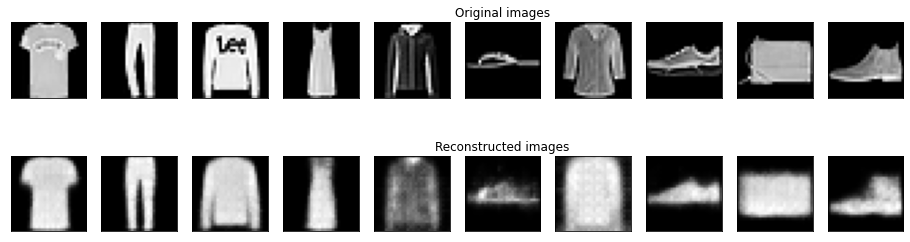

	 partial train loss (single batch): 0.022923
	 partial train loss (single batch): 0.022257
	 partial train loss (single batch): 0.023832
	 partial train loss (single batch): 0.022234
	 partial train loss (single batch): 0.022954
	 partial train loss (single batch): 0.021060
	 partial train loss (single batch): 0.022408
	 partial train loss (single batch): 0.024050
	 partial train loss (single batch): 0.022596
	 partial train loss (single batch): 0.023564
	 partial train loss (single batch): 0.023970
	 partial train loss (single batch): 0.024179
	 partial train loss (single batch): 0.024597
	 partial train loss (single batch): 0.023653
	 partial train loss (single batch): 0.023913
	 partial train loss (single batch): 0.022178
	 partial train loss (single batch): 0.022001
	 partial train loss (single batch): 0.023044
	 partial train loss (single batch): 0.022101
	 partial train loss (single batch): 0.022341
	 partial train loss (single batch): 0.025251
	 partial train loss (single batch

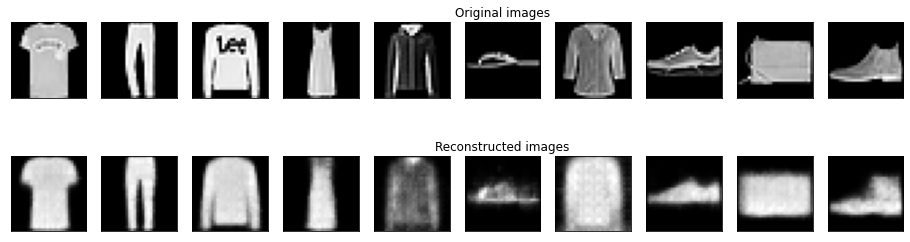

	 partial train loss (single batch): 0.022471
	 partial train loss (single batch): 0.021858
	 partial train loss (single batch): 0.023476
	 partial train loss (single batch): 0.021749
	 partial train loss (single batch): 0.022584
	 partial train loss (single batch): 0.020651
	 partial train loss (single batch): 0.021974
	 partial train loss (single batch): 0.023669
	 partial train loss (single batch): 0.022197
	 partial train loss (single batch): 0.023194
	 partial train loss (single batch): 0.023586
	 partial train loss (single batch): 0.023829
	 partial train loss (single batch): 0.024261
	 partial train loss (single batch): 0.023213
	 partial train loss (single batch): 0.023569
	 partial train loss (single batch): 0.021763
	 partial train loss (single batch): 0.021617
	 partial train loss (single batch): 0.022594
	 partial train loss (single batch): 0.021758
	 partial train loss (single batch): 0.021962
	 partial train loss (single batch): 0.024821
	 partial train loss (single batch

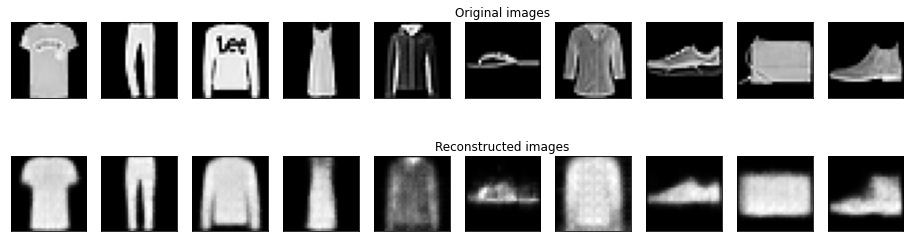

	 partial train loss (single batch): 0.022054
	 partial train loss (single batch): 0.021554
	 partial train loss (single batch): 0.023150
	 partial train loss (single batch): 0.021415
	 partial train loss (single batch): 0.022299
	 partial train loss (single batch): 0.020381
	 partial train loss (single batch): 0.021649
	 partial train loss (single batch): 0.023308
	 partial train loss (single batch): 0.021871
	 partial train loss (single batch): 0.022853
	 partial train loss (single batch): 0.023203
	 partial train loss (single batch): 0.023466
	 partial train loss (single batch): 0.023856
	 partial train loss (single batch): 0.022877
	 partial train loss (single batch): 0.023165
	 partial train loss (single batch): 0.021436
	 partial train loss (single batch): 0.021255
	 partial train loss (single batch): 0.022222
	 partial train loss (single batch): 0.021401
	 partial train loss (single batch): 0.021657
	 partial train loss (single batch): 0.024524
	 partial train loss (single batch

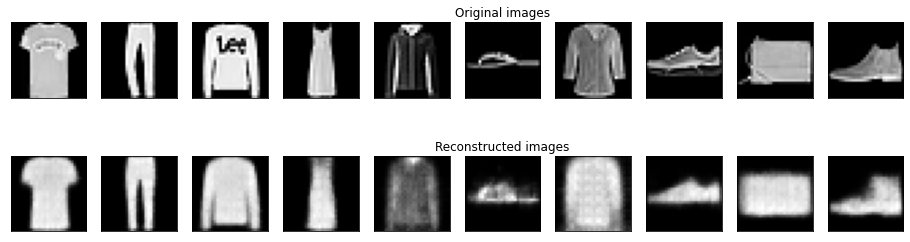

	 partial train loss (single batch): 0.021744
	 partial train loss (single batch): 0.021229
	 partial train loss (single batch): 0.022892
	 partial train loss (single batch): 0.021039
	 partial train loss (single batch): 0.022007
	 partial train loss (single batch): 0.020118
	 partial train loss (single batch): 0.021333
	 partial train loss (single batch): 0.023076
	 partial train loss (single batch): 0.021587
	 partial train loss (single batch): 0.022589
	 partial train loss (single batch): 0.022949
	 partial train loss (single batch): 0.023201
	 partial train loss (single batch): 0.023588
	 partial train loss (single batch): 0.022605
	 partial train loss (single batch): 0.022908
	 partial train loss (single batch): 0.021140
	 partial train loss (single batch): 0.021002
	 partial train loss (single batch): 0.021931
	 partial train loss (single batch): 0.021152
	 partial train loss (single batch): 0.021391
	 partial train loss (single batch): 0.024246
	 partial train loss (single batch

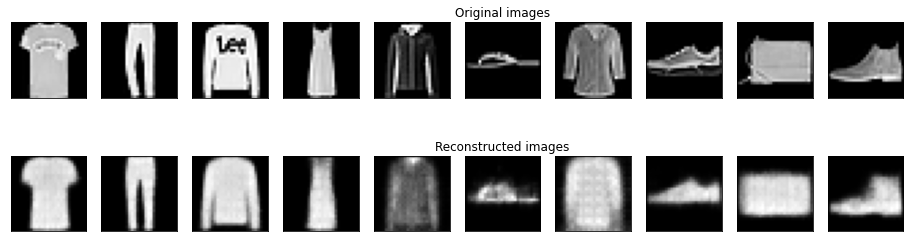

	 partial train loss (single batch): 0.021421
	 partial train loss (single batch): 0.020918
	 partial train loss (single batch): 0.022639
	 partial train loss (single batch): 0.020755
	 partial train loss (single batch): 0.021776
	 partial train loss (single batch): 0.019889
	 partial train loss (single batch): 0.021110
	 partial train loss (single batch): 0.022865
	 partial train loss (single batch): 0.021334
	 partial train loss (single batch): 0.022371
	 partial train loss (single batch): 0.022727
	 partial train loss (single batch): 0.022980
	 partial train loss (single batch): 0.023318
	 partial train loss (single batch): 0.022366
	 partial train loss (single batch): 0.022663
	 partial train loss (single batch): 0.020890
	 partial train loss (single batch): 0.020760
	 partial train loss (single batch): 0.021665
	 partial train loss (single batch): 0.020924
	 partial train loss (single batch): 0.021159
	 partial train loss (single batch): 0.024010
	 partial train loss (single batch

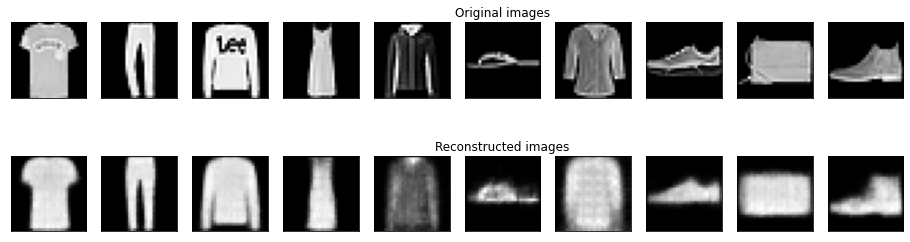

	 partial train loss (single batch): 0.021159
	 partial train loss (single batch): 0.020704
	 partial train loss (single batch): 0.022425
	 partial train loss (single batch): 0.020519
	 partial train loss (single batch): 0.021525
	 partial train loss (single batch): 0.019657
	 partial train loss (single batch): 0.020904
	 partial train loss (single batch): 0.022680
	 partial train loss (single batch): 0.021088
	 partial train loss (single batch): 0.022151
	 partial train loss (single batch): 0.022504
	 partial train loss (single batch): 0.022732
	 partial train loss (single batch): 0.023039
	 partial train loss (single batch): 0.022147
	 partial train loss (single batch): 0.022425
	 partial train loss (single batch): 0.020614
	 partial train loss (single batch): 0.020510
	 partial train loss (single batch): 0.021431
	 partial train loss (single batch): 0.020697
	 partial train loss (single batch): 0.020924
	 partial train loss (single batch): 0.023803
	 partial train loss (single batch

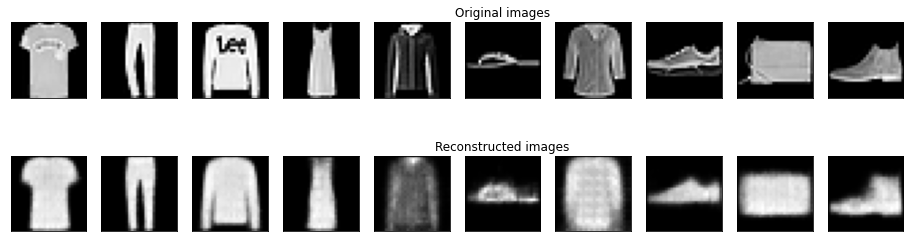

	 partial train loss (single batch): 0.020926
	 partial train loss (single batch): 0.020485
	 partial train loss (single batch): 0.022241
	 partial train loss (single batch): 0.020256
	 partial train loss (single batch): 0.021332
	 partial train loss (single batch): 0.019432
	 partial train loss (single batch): 0.020730
	 partial train loss (single batch): 0.022478
	 partial train loss (single batch): 0.020922
	 partial train loss (single batch): 0.021956
	 partial train loss (single batch): 0.022316
	 partial train loss (single batch): 0.022567
	 partial train loss (single batch): 0.022872
	 partial train loss (single batch): 0.021966
	 partial train loss (single batch): 0.022287
	 partial train loss (single batch): 0.020422
	 partial train loss (single batch): 0.020355
	 partial train loss (single batch): 0.021258
	 partial train loss (single batch): 0.020542
	 partial train loss (single batch): 0.020759
	 partial train loss (single batch): 0.023615
	 partial train loss (single batch

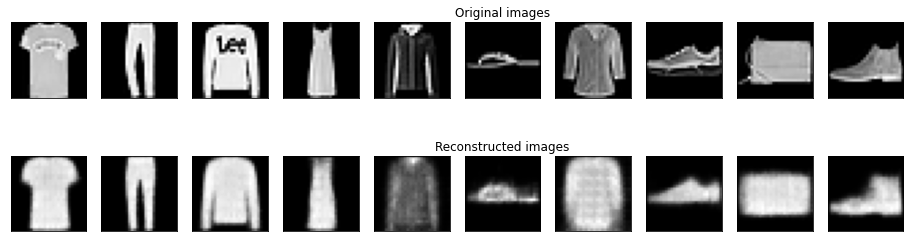

	 partial train loss (single batch): 0.020749
	 partial train loss (single batch): 0.020337
	 partial train loss (single batch): 0.022104
	 partial train loss (single batch): 0.020076
	 partial train loss (single batch): 0.021120
	 partial train loss (single batch): 0.019252
	 partial train loss (single batch): 0.020598
	 partial train loss (single batch): 0.022314
	 partial train loss (single batch): 0.020765
	 partial train loss (single batch): 0.021764
	 partial train loss (single batch): 0.022180
	 partial train loss (single batch): 0.022398
	 partial train loss (single batch): 0.022680
	 partial train loss (single batch): 0.021810
	 partial train loss (single batch): 0.022140
	 partial train loss (single batch): 0.020243
	 partial train loss (single batch): 0.020170
	 partial train loss (single batch): 0.021072
	 partial train loss (single batch): 0.020362
	 partial train loss (single batch): 0.020596
	 partial train loss (single batch): 0.023417
	 partial train loss (single batch

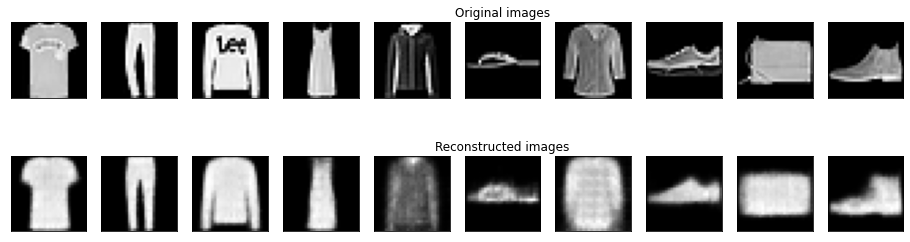

	 partial train loss (single batch): 0.020576
	 partial train loss (single batch): 0.020238
	 partial train loss (single batch): 0.021946
	 partial train loss (single batch): 0.019943
	 partial train loss (single batch): 0.020936
	 partial train loss (single batch): 0.019130
	 partial train loss (single batch): 0.020490
	 partial train loss (single batch): 0.022201
	 partial train loss (single batch): 0.020603
	 partial train loss (single batch): 0.021594
	 partial train loss (single batch): 0.022023
	 partial train loss (single batch): 0.022251
	 partial train loss (single batch): 0.022538
	 partial train loss (single batch): 0.021638
	 partial train loss (single batch): 0.022017
	 partial train loss (single batch): 0.020090
	 partial train loss (single batch): 0.020016
	 partial train loss (single batch): 0.020909
	 partial train loss (single batch): 0.020249
	 partial train loss (single batch): 0.020440
	 partial train loss (single batch): 0.023289
	 partial train loss (single batch

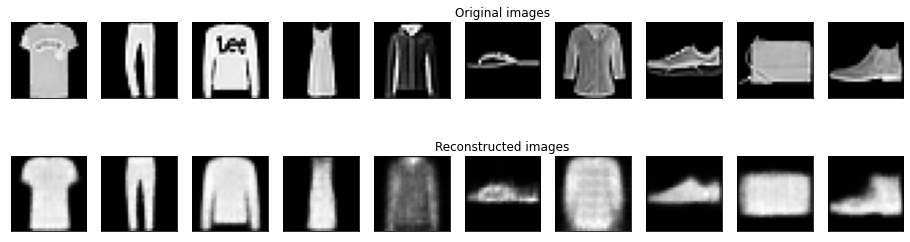

	 partial train loss (single batch): 0.020424
	 partial train loss (single batch): 0.020109
	 partial train loss (single batch): 0.021820
	 partial train loss (single batch): 0.019795
	 partial train loss (single batch): 0.020793
	 partial train loss (single batch): 0.018965
	 partial train loss (single batch): 0.020387
	 partial train loss (single batch): 0.022060
	 partial train loss (single batch): 0.020491
	 partial train loss (single batch): 0.021396
	 partial train loss (single batch): 0.021918
	 partial train loss (single batch): 0.022072
	 partial train loss (single batch): 0.022379
	 partial train loss (single batch): 0.021475
	 partial train loss (single batch): 0.021866
	 partial train loss (single batch): 0.019961
	 partial train loss (single batch): 0.019798
	 partial train loss (single batch): 0.020770
	 partial train loss (single batch): 0.020078
	 partial train loss (single batch): 0.020309
	 partial train loss (single batch): 0.023153
	 partial train loss (single batch

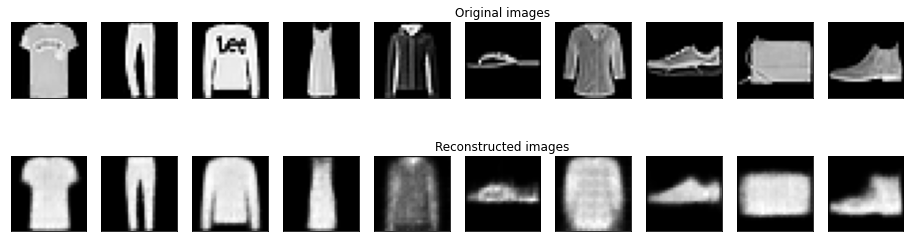

	 partial train loss (single batch): 0.020278
	 partial train loss (single batch): 0.019983
	 partial train loss (single batch): 0.021684
	 partial train loss (single batch): 0.019665
	 partial train loss (single batch): 0.020623
	 partial train loss (single batch): 0.018809
	 partial train loss (single batch): 0.020245
	 partial train loss (single batch): 0.021900
	 partial train loss (single batch): 0.020354
	 partial train loss (single batch): 0.021221
	 partial train loss (single batch): 0.021793
	 partial train loss (single batch): 0.021920
	 partial train loss (single batch): 0.022214
	 partial train loss (single batch): 0.021352
	 partial train loss (single batch): 0.021715
	 partial train loss (single batch): 0.019830
	 partial train loss (single batch): 0.019606
	 partial train loss (single batch): 0.020667
	 partial train loss (single batch): 0.019921
	 partial train loss (single batch): 0.020183
	 partial train loss (single batch): 0.023006
	 partial train loss (single batch

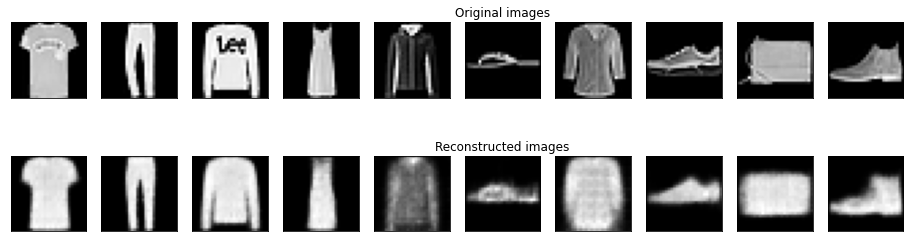

	 partial train loss (single batch): 0.020188
	 partial train loss (single batch): 0.019895
	 partial train loss (single batch): 0.021597
	 partial train loss (single batch): 0.019565
	 partial train loss (single batch): 0.020532
	 partial train loss (single batch): 0.018674
	 partial train loss (single batch): 0.020146
	 partial train loss (single batch): 0.021785
	 partial train loss (single batch): 0.020270
	 partial train loss (single batch): 0.021082
	 partial train loss (single batch): 0.021724
	 partial train loss (single batch): 0.021791
	 partial train loss (single batch): 0.022082
	 partial train loss (single batch): 0.021249
	 partial train loss (single batch): 0.021588
	 partial train loss (single batch): 0.019733
	 partial train loss (single batch): 0.019470
	 partial train loss (single batch): 0.020593
	 partial train loss (single batch): 0.019823
	 partial train loss (single batch): 0.020090
	 partial train loss (single batch): 0.022913
	 partial train loss (single batch

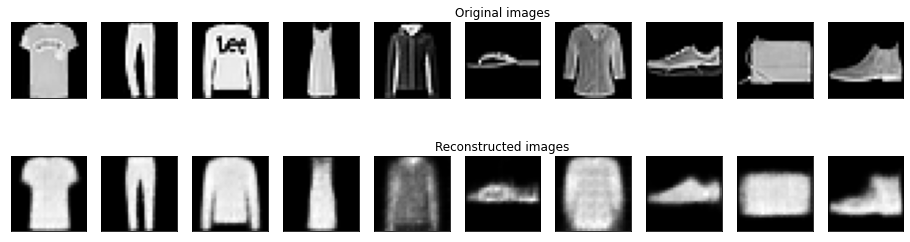

	 partial train loss (single batch): 0.020092
	 partial train loss (single batch): 0.019782
	 partial train loss (single batch): 0.021471
	 partial train loss (single batch): 0.019458
	 partial train loss (single batch): 0.020390
	 partial train loss (single batch): 0.018578
	 partial train loss (single batch): 0.020019
	 partial train loss (single batch): 0.021682
	 partial train loss (single batch): 0.020141
	 partial train loss (single batch): 0.020930
	 partial train loss (single batch): 0.021596
	 partial train loss (single batch): 0.021630
	 partial train loss (single batch): 0.021963
	 partial train loss (single batch): 0.021078
	 partial train loss (single batch): 0.021470
	 partial train loss (single batch): 0.019621
	 partial train loss (single batch): 0.019302
	 partial train loss (single batch): 0.020499
	 partial train loss (single batch): 0.019679
	 partial train loss (single batch): 0.019968
	 partial train loss (single batch): 0.022792
	 partial train loss (single batch

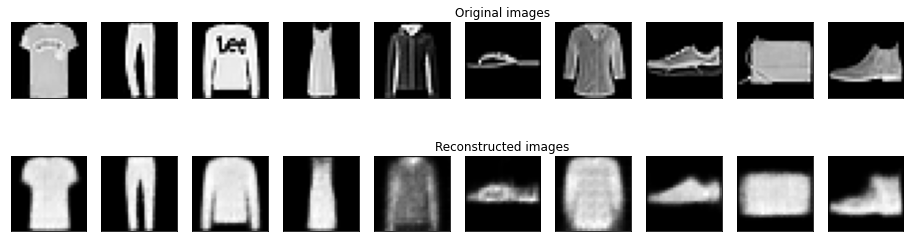

	 partial train loss (single batch): 0.020014
	 partial train loss (single batch): 0.019674
	 partial train loss (single batch): 0.021370
	 partial train loss (single batch): 0.019347
	 partial train loss (single batch): 0.020303
	 partial train loss (single batch): 0.018444
	 partial train loss (single batch): 0.019916
	 partial train loss (single batch): 0.021577
	 partial train loss (single batch): 0.020023
	 partial train loss (single batch): 0.020822
	 partial train loss (single batch): 0.021528
	 partial train loss (single batch): 0.021490
	 partial train loss (single batch): 0.021846
	 partial train loss (single batch): 0.020934
	 partial train loss (single batch): 0.021381
	 partial train loss (single batch): 0.019528
	 partial train loss (single batch): 0.019145
	 partial train loss (single batch): 0.020439
	 partial train loss (single batch): 0.019566
	 partial train loss (single batch): 0.019876
	 partial train loss (single batch): 0.022680
	 partial train loss (single batch

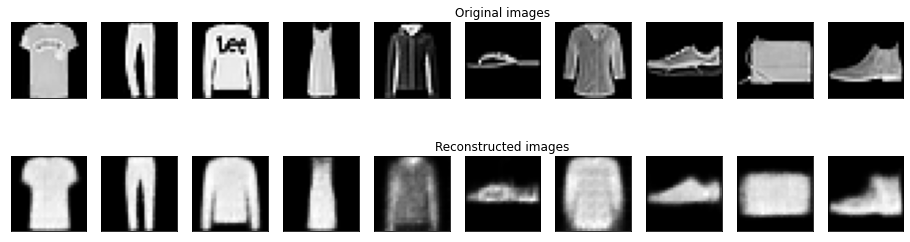

	 partial train loss (single batch): 0.019914
	 partial train loss (single batch): 0.019565
	 partial train loss (single batch): 0.021253
	 partial train loss (single batch): 0.019258
	 partial train loss (single batch): 0.020207
	 partial train loss (single batch): 0.018358
	 partial train loss (single batch): 0.019797
	 partial train loss (single batch): 0.021488
	 partial train loss (single batch): 0.019936
	 partial train loss (single batch): 0.020703
	 partial train loss (single batch): 0.021439
	 partial train loss (single batch): 0.021357
	 partial train loss (single batch): 0.021766
	 partial train loss (single batch): 0.020813
	 partial train loss (single batch): 0.021305
	 partial train loss (single batch): 0.019443
	 partial train loss (single batch): 0.019034
	 partial train loss (single batch): 0.020366
	 partial train loss (single batch): 0.019459
	 partial train loss (single batch): 0.019815
	 partial train loss (single batch): 0.022558
	 partial train loss (single batch

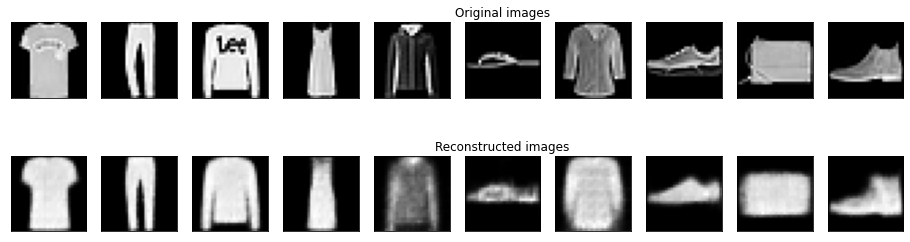

	 partial train loss (single batch): 0.019814
	 partial train loss (single batch): 0.019451
	 partial train loss (single batch): 0.021134
	 partial train loss (single batch): 0.019205
	 partial train loss (single batch): 0.020132
	 partial train loss (single batch): 0.018293
	 partial train loss (single batch): 0.019698
	 partial train loss (single batch): 0.021400
	 partial train loss (single batch): 0.019853
	 partial train loss (single batch): 0.020584
	 partial train loss (single batch): 0.021368
	 partial train loss (single batch): 0.021248
	 partial train loss (single batch): 0.021659
	 partial train loss (single batch): 0.020685
	 partial train loss (single batch): 0.021233
	 partial train loss (single batch): 0.019362
	 partial train loss (single batch): 0.018917
	 partial train loss (single batch): 0.020268
	 partial train loss (single batch): 0.019362
	 partial train loss (single batch): 0.019711
	 partial train loss (single batch): 0.022464
	 partial train loss (single batch

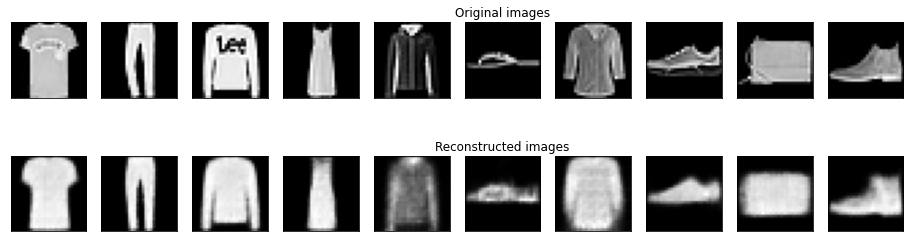

	 partial train loss (single batch): 0.019730
	 partial train loss (single batch): 0.019375
	 partial train loss (single batch): 0.021055
	 partial train loss (single batch): 0.019161
	 partial train loss (single batch): 0.020034
	 partial train loss (single batch): 0.018219
	 partial train loss (single batch): 0.019592
	 partial train loss (single batch): 0.021333
	 partial train loss (single batch): 0.019795
	 partial train loss (single batch): 0.020491
	 partial train loss (single batch): 0.021275
	 partial train loss (single batch): 0.021139
	 partial train loss (single batch): 0.021566
	 partial train loss (single batch): 0.020580
	 partial train loss (single batch): 0.021182
	 partial train loss (single batch): 0.019301
	 partial train loss (single batch): 0.018814
	 partial train loss (single batch): 0.020204
	 partial train loss (single batch): 0.019289
	 partial train loss (single batch): 0.019643
	 partial train loss (single batch): 0.022386
	 partial train loss (single batch

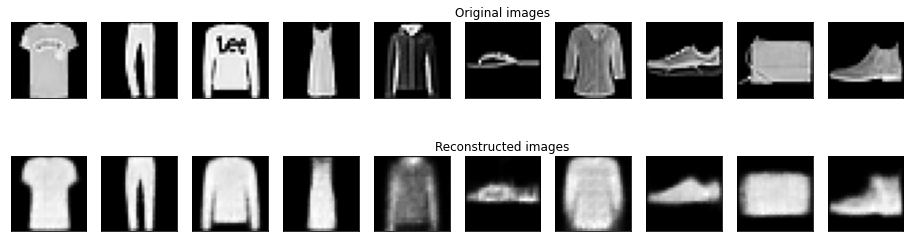

	 partial train loss (single batch): 0.019643
	 partial train loss (single batch): 0.019298
	 partial train loss (single batch): 0.020966
	 partial train loss (single batch): 0.019112
	 partial train loss (single batch): 0.019980
	 partial train loss (single batch): 0.018173
	 partial train loss (single batch): 0.019541
	 partial train loss (single batch): 0.021272
	 partial train loss (single batch): 0.019759
	 partial train loss (single batch): 0.020412
	 partial train loss (single batch): 0.021184
	 partial train loss (single batch): 0.021029
	 partial train loss (single batch): 0.021490
	 partial train loss (single batch): 0.020486
	 partial train loss (single batch): 0.021117
	 partial train loss (single batch): 0.019222
	 partial train loss (single batch): 0.018731
	 partial train loss (single batch): 0.020112
	 partial train loss (single batch): 0.019213
	 partial train loss (single batch): 0.019564
	 partial train loss (single batch): 0.022324
	 partial train loss (single batch

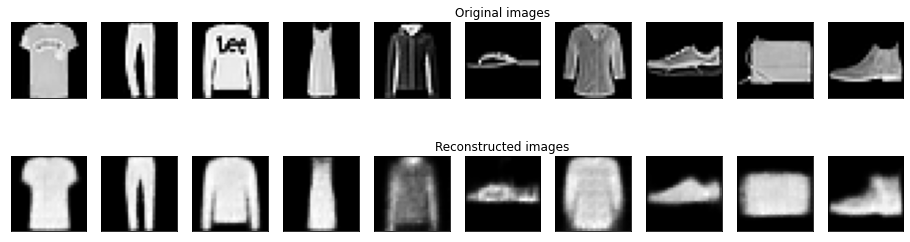

	 partial train loss (single batch): 0.019555
	 partial train loss (single batch): 0.019245
	 partial train loss (single batch): 0.020920
	 partial train loss (single batch): 0.019052
	 partial train loss (single batch): 0.019894
	 partial train loss (single batch): 0.018122
	 partial train loss (single batch): 0.019491
	 partial train loss (single batch): 0.021197
	 partial train loss (single batch): 0.019699
	 partial train loss (single batch): 0.020317
	 partial train loss (single batch): 0.021107
	 partial train loss (single batch): 0.020944
	 partial train loss (single batch): 0.021411
	 partial train loss (single batch): 0.020385
	 partial train loss (single batch): 0.021053
	 partial train loss (single batch): 0.019156
	 partial train loss (single batch): 0.018669
	 partial train loss (single batch): 0.020044
	 partial train loss (single batch): 0.019158
	 partial train loss (single batch): 0.019491
	 partial train loss (single batch): 0.022253
	 partial train loss (single batch

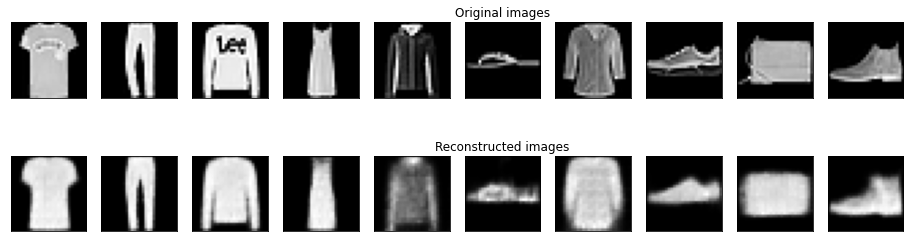

	 partial train loss (single batch): 0.019463
	 partial train loss (single batch): 0.019183
	 partial train loss (single batch): 0.020848
	 partial train loss (single batch): 0.018973
	 partial train loss (single batch): 0.019839
	 partial train loss (single batch): 0.018068
	 partial train loss (single batch): 0.019404
	 partial train loss (single batch): 0.021122
	 partial train loss (single batch): 0.019650
	 partial train loss (single batch): 0.020246
	 partial train loss (single batch): 0.021037
	 partial train loss (single batch): 0.020882
	 partial train loss (single batch): 0.021318
	 partial train loss (single batch): 0.020300
	 partial train loss (single batch): 0.020974
	 partial train loss (single batch): 0.019096
	 partial train loss (single batch): 0.018596
	 partial train loss (single batch): 0.019969
	 partial train loss (single batch): 0.019075
	 partial train loss (single batch): 0.019434
	 partial train loss (single batch): 0.022188
	 partial train loss (single batch

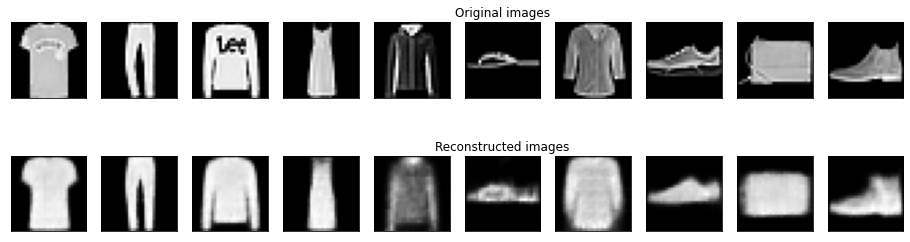

	 partial train loss (single batch): 0.019414
	 partial train loss (single batch): 0.019073
	 partial train loss (single batch): 0.020773
	 partial train loss (single batch): 0.018907
	 partial train loss (single batch): 0.019812
	 partial train loss (single batch): 0.017986
	 partial train loss (single batch): 0.019341
	 partial train loss (single batch): 0.021073
	 partial train loss (single batch): 0.019600
	 partial train loss (single batch): 0.020181
	 partial train loss (single batch): 0.020942
	 partial train loss (single batch): 0.020819
	 partial train loss (single batch): 0.021230
	 partial train loss (single batch): 0.020224
	 partial train loss (single batch): 0.020928
	 partial train loss (single batch): 0.019035
	 partial train loss (single batch): 0.018549
	 partial train loss (single batch): 0.019929
	 partial train loss (single batch): 0.019005
	 partial train loss (single batch): 0.019396
	 partial train loss (single batch): 0.022127
	 partial train loss (single batch

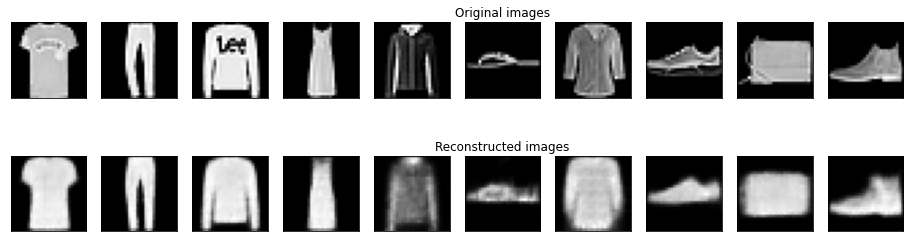

	 partial train loss (single batch): 0.019357
	 partial train loss (single batch): 0.019034
	 partial train loss (single batch): 0.020709
	 partial train loss (single batch): 0.018880
	 partial train loss (single batch): 0.019773
	 partial train loss (single batch): 0.017964
	 partial train loss (single batch): 0.019300
	 partial train loss (single batch): 0.021040
	 partial train loss (single batch): 0.019572
	 partial train loss (single batch): 0.020116
	 partial train loss (single batch): 0.020893
	 partial train loss (single batch): 0.020762
	 partial train loss (single batch): 0.021147
	 partial train loss (single batch): 0.020165
	 partial train loss (single batch): 0.020870
	 partial train loss (single batch): 0.018991
	 partial train loss (single batch): 0.018494
	 partial train loss (single batch): 0.019904
	 partial train loss (single batch): 0.018936
	 partial train loss (single batch): 0.019356
	 partial train loss (single batch): 0.022070
	 partial train loss (single batch

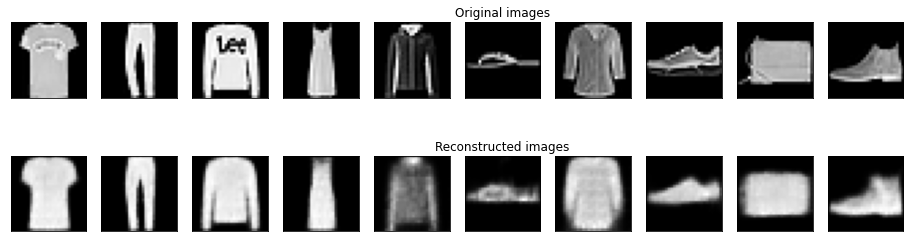

	 partial train loss (single batch): 0.019315
	 partial train loss (single batch): 0.018964
	 partial train loss (single batch): 0.020654
	 partial train loss (single batch): 0.018802
	 partial train loss (single batch): 0.019735
	 partial train loss (single batch): 0.017876
	 partial train loss (single batch): 0.019242
	 partial train loss (single batch): 0.020998
	 partial train loss (single batch): 0.019522
	 partial train loss (single batch): 0.020082
	 partial train loss (single batch): 0.020843
	 partial train loss (single batch): 0.020710
	 partial train loss (single batch): 0.021091
	 partial train loss (single batch): 0.020116
	 partial train loss (single batch): 0.020842
	 partial train loss (single batch): 0.018967
	 partial train loss (single batch): 0.018450
	 partial train loss (single batch): 0.019901
	 partial train loss (single batch): 0.018867
	 partial train loss (single batch): 0.019342
	 partial train loss (single batch): 0.022012
	 partial train loss (single batch

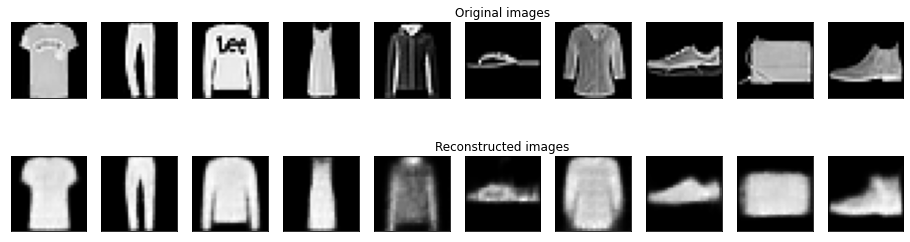

In [8]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

## final evaluation on the test set

In [9]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.01982533559203148

## how the reconstruction losses decrease over the epochs

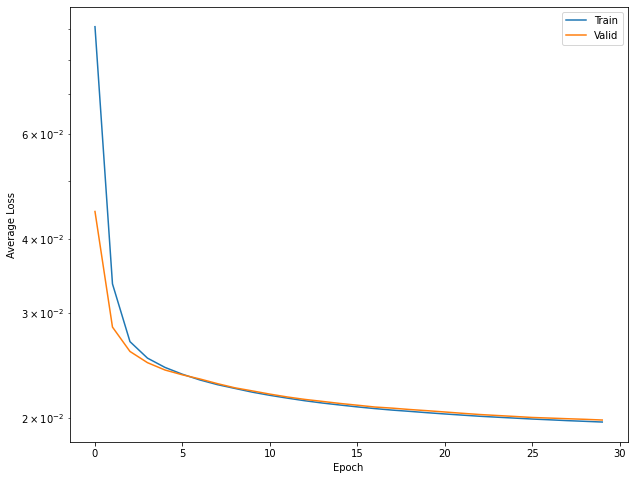

In [10]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

## Generate new samples from the random latent code

tensor([-12.6642,  -1.4678,   6.7835,   2.1332])
tensor([15.3670, 15.3139, 15.6249, 14.4652])


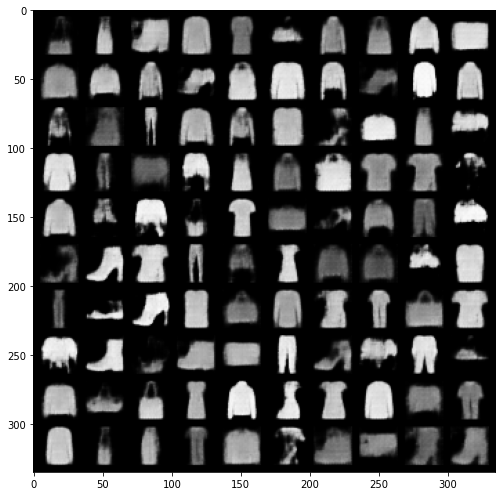

In [13]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = next(iter(test_loader))
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, encoded_space_dim)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

## Visualize the latent space with t-SNE

In [14]:
from tqdm import tqdm
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:11<00:00, 838.59it/s]


Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0            3.890736        22.010866         8.817139        17.543730   
1          -31.615694        -4.380224        26.363380       -11.405475   
2          -15.872120       -12.690190       -28.835327       -32.915550   
3          -15.110766        -4.741380       -24.940069       -16.990635   
4          -11.267826        -8.166026        11.120749        -3.050624   
...               ...              ...              ...              ...   
9995         7.051089        13.515445        22.465561        26.705990   
9996       -12.058001        -1.809009       -12.871530        -4.355443   
9997       -24.102852         5.954823        -6.507573        23.987043   
9998       -23.657356       -12.208315       -34.674656        -6.727136   
9999        -0.148835        12.782494         4.247196         2.925023   

      label  
0         9  
1         2  
2         1  
3         1  
4         6  
...     ...  
9995      9  
9996      1  
9997      8  
9998      1  
9999      5  

[10000 rows x 5 columns]

In [15]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

## apply a dimensionality reduction, t-SNE 

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()